In [1]:
from disent.systems.vae import VaeSystem
from disent.visualize.util import plt_images_grid, plt_images_minimal_square, reconstructions_to_images
from disent.visualize.visualize_dataset import visualise_get_still_images, visualise_get_animations
from disent.visualize.visualize_model import latent_traversal_1d_multi_dim
from disent.util import to_numpy, load_model, save_model

import numpy as np
import torch
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import os

import imageio

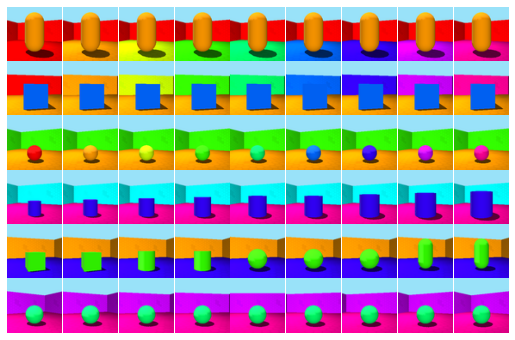

In [2]:
images = visualise_get_still_images('3dshapes', 9)
fig, axs = plt_images_grid(images, figsize_ratio=1)


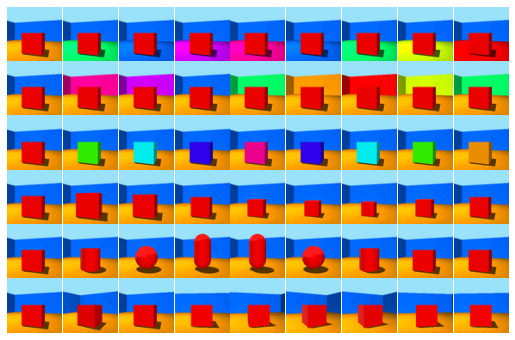

In [5]:
frames = visualise_get_animations('3dshapes', 1, 9)[0]
fig, axs = plt_images_grid(frames)

# Visualisation

# HELPER

In [4]:
def plot_sampled(system, num_samples=9):
    samples = []
    for i in range(num_samples):
        while True:
            temp = system.model.random_decoded_samples(1)
            temp = temp.cpu().detach().numpy()
            temp = np.uint8(temp * 255)
            temp = np.moveaxis(temp.reshape(-1, 3, 64, 64), 1, -1)
            if True: #temp.std() > 1: # std produces smoother results than mean
                samples.append(temp[0])
                break

    # plt_make_subplots_grid(samples, figsize=(10, 10))
    plt_make_subplots_grid(samples)
    plt.show()

def get_latent_outputs(system, num_samples=1000):
    means, logvars = [], []
    for i, batch in enumerate(DataLoader(system.dataset_train, batch_size=1, shuffle=True)):
        try:
            x, _ = batch
        except:
            x = batch
        z_mean, z_logvar = system.model.encode_gaussian(x.cuda())
        means.append(z_mean.cpu().detach().numpy()[0])
        logvars.append(z_logvar.cpu().detach().numpy()[0])
        if i >= num_samples:
            break
    means, logvars = np.array(means), np.array(logvars)
    return means, logvars #, np.exp(logvars).mean(axis=0)
    
def plot_system_mean_and_var(system, num_samples=100):
    means, logvars = get_latent_outputs(system, num_samples)
    
    means_mean, means_std = means.mean(axis=0), means.std(axis=0)
    logvars = np.exp(logvars) ** 0.5
    logvar_mean, logvar_std = logvars.mean(axis=0), logvars.std(axis=0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    
    ax1.set_title('z_mean')
    ax1.set_xlabel('idx')
    ax1.set_ylabel('value')
    ax1.errorbar(np.arange(len(means_mean)), means_mean, yerr=means_std)

    ax2.set_title('exp(z_logvar) ** 0.5')
    ax2.set_xlabel('idx')
    ax2.set_ylabel('value')
    ax2.errorbar(np.arange(len(logvar_mean)), logvar_mean, yerr=logvar_std)

def plt_traverse_latent_space(system, num_samples=16, values=11, dimensions=None, figsize_ratio=0.75):
    obs = torch.stack(system.dataset_train.sample_observations(num_samples)).cuda()
    z_mean, z_logvar = system.model.encode_gaussian(obs)
    for i in range(num_samples):
        images = latent_traversal_1d_multi_dim(system.model.decode, z_mean[i, :], dimensions=dimensions, values=values)
        plt_images_grid(images, figsize_ratio=figsize_ratio)
    
def plt_sample_observations_and_reconstruct(system, num_samples=16, figsize_ratio=0.75):
    obs = torch.stack(system.dataset_train.sample_observations(num_samples)).cuda()
    x_recon, z_mean, z_logvar, z = system.model.forward_deterministic(obs)
    plt_images_minimal_square(reconstructions_to_images(obs), figsize_ratio=figsize_ratio)
    plt_images_minimal_square(reconstructions_to_images(x_recon), figsize_ratio=figsize_ratio)
    return obs, x_recon
    
def train_system(loss='ada-gvae', dataset='dsprites', model='simple-fc', z_dim=10, epochs=1, steps=None, save_path=None, load_path=None, train=True):
    system = VaeSystem(dataset_train=dataset, model=model, loss=loss, hparams=dict(lr=0.001, num_workers=8, batch_size=64, z_dim=z_dim))
    
    if load_path:
        # system.load_from_checkpoint(checkpoint_path=PATH)
        system = load_model(system, load_path, cuda=False)

    if train:
        trainer = system.quick_train(epochs=epochs, steps=steps)

        if save_path:
            # trainer.save_checkpoint(save_path)
            save_model(system, save_path)
    
    return system #, trainer
    

In [5]:
# try: del system
# except: pass
# try: del trainer
# except: pass

# PATH = 'data/trained-e10-3dshapes-simple-fc.ckpt'
# system = train_system(loss='beta-vae', dataset='3dshapes', epochs=10, steps=None, model='simple-fc', save_path=PATH, load_path=None, train=True)
# system = system.cuda()

In [6]:
# plot_sampled(system, 10)
system2 = train_system(loss='beta-vae', dataset='3dshapes', epochs=1, steps=None, model='simple-fc', save_path=None, load_path='data/trained-e1-3dshapes-simple-fc.ckpt', train=False)
system2 = system2.cuda()

[MODEL]: loaded data/trained-e1-3dshapes-simple-fc.ckpt (cuda: False)


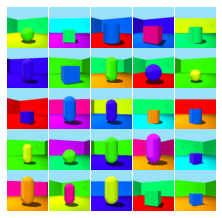

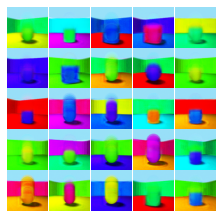

In [7]:
plt_sample_observations_and_reconstruct(system2, num_samples=25);

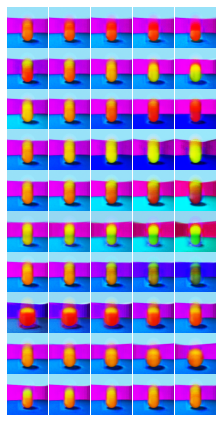

In [8]:
plt_traverse_latent_space(system2, num_samples=1, values=5, dimensions=None)

## MINI TESTS

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 774   
9  | model.gaussian_encoder.enc3logvar | Linear               | 774   
10 | model.decoder                     | DecoderSimpl

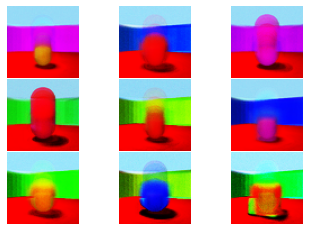

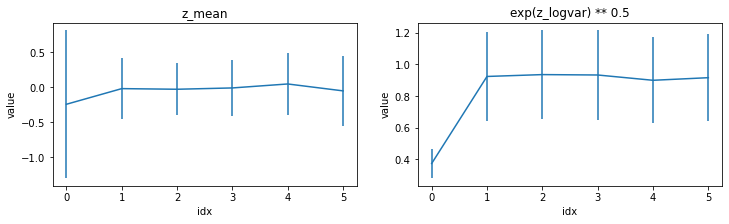

In [128]:
fc_system, fc_trainer = train_system(loss='ada-gvae', z_dim=6, epochs=1)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 387   
9  | model.gaussian_encoder.enc3logvar | Linear               | 387   
10 | model.decoder                     | DecoderSimpl

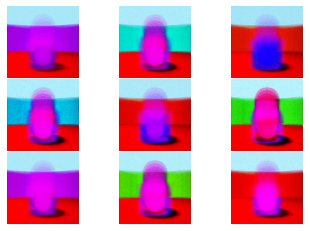

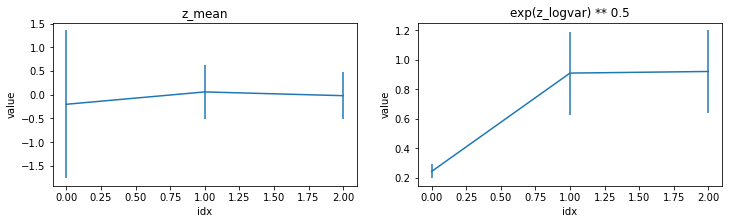

In [129]:


fc_system, fc_trainer = train_system(loss='ada-gvae', z_dim=3, epochs=1)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 1 K   
9  | model.gaussian_encoder.enc3logvar | Linear               | 1 K   
10 | model.decoder                     | DecoderSimpl

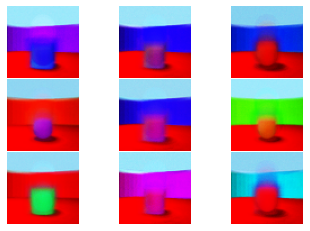

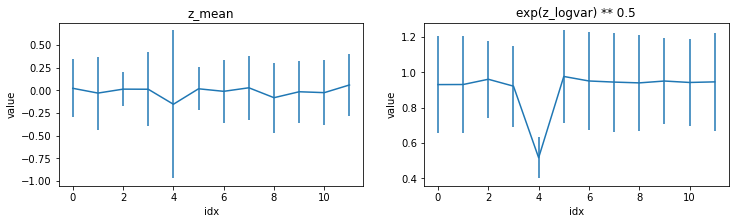

In [130]:
fc_system, fc_trainer = train_system(loss='ada-gvae', z_dim=12, epochs=1)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

In [ ]:
z_mean, z_logvar = N()



INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 774   
9  | model.gaussian_encoder.enc3logvar | Linear               | 774   
10 | model.decoder                     | DecoderSimpl

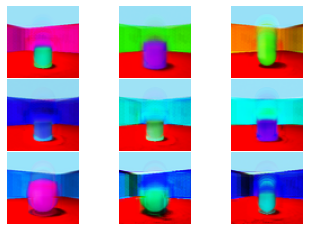

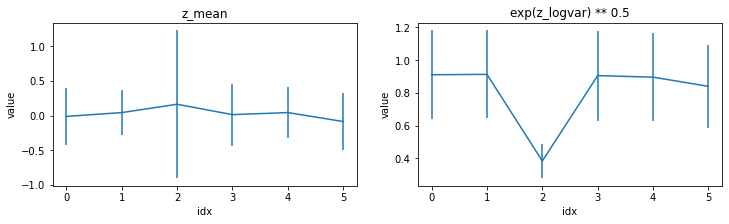

In [138]:
fc_system, fc_trainer = train_system(loss='beta-vae', z_dim=6, epochs=5)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 387   
9  | model.gaussian_encoder.enc3logvar | Linear               | 387   
10 | model.decoder                     | DecoderSimpl

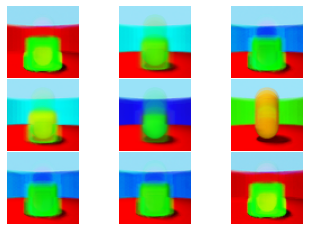

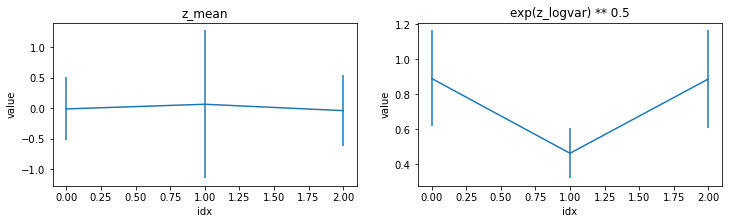

In [136]:
fc_system, fc_trainer = train_system(loss='beta-vae', z_dim=3, epochs=5)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 1 K   
9  | model.gaussian_encoder.enc3logvar | Linear               | 1 K   
10 | model.decoder                     | DecoderSimpl

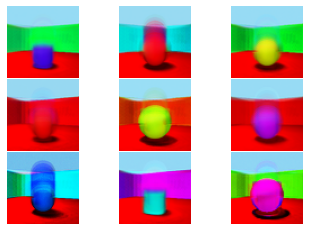

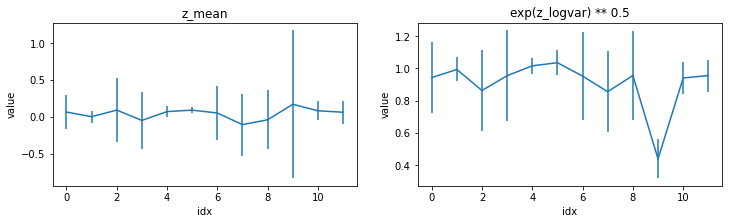

In [137]:
fc_system, fc_trainer = train_system(loss='beta-vae', z_dim=12, epochs=5)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

In [ ]:
[6, 6, 6, 24 , 3, 2]